Mount Google Drive to get access to folders within Google Drive.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Import libraries and define global variables



In [2]:
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

torch.manual_seed(1) #Set the random seed

PROJECT_FOLDER = '/content/drive/My Drive/ECE496/machine_learning_pipeline/'
FEATURE_FOLDER = PROJECT_FOLDER + 'vgg16_gesture_training_dataset_features/'

Fetch the features dataset, shuffle the indices of the features dataset list to randomize the order of the labeled features, then split up the features dataset into a training set, a validation set, and a test set.

In [3]:
def get_data_loader(batch_size):
    features_dataset = datasets.DatasetFolder(FEATURE_FOLDER, loader=torch.load, extensions='.tensor')

    #Split the dataset into a training set, a validation set, and a test set.
    indices = []
    for i in range(len(features_dataset)):
        indices.append(i)
      
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices) #Randomize the images in our dataset

    split_train = int(len(indices) * 0.8)
    split_val = int(len(indices) * 0.9)

    train_indices = indices[:split_train]
    val_indices = indices[split_train:split_val]
    test_indices = indices[split_val:]

    #Training Set
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(features_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    #Validation Set
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(features_dataset, batch_size=batch_size,
                                             sampler=val_sampler)
    #Test Set
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(features_dataset, batch_size=batch_size,
                                              sampler=test_sampler)

    print("Number of Training Images: " + str(len(train_indices)))
    print("Number of Validation Images: " + str(len(val_indices)))
    print("Number of Test Images: " + str(len(test_indices)))

    return train_loader, val_loader, test_loader

Training and Evaluation

In [8]:
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    i = 0
    
    for inputs, labels in iter(loader):
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        pred = outputs.max(1, keepdim=True)[1]
        total_acc += pred.eq(labels.view_as(pred)).sum().item()
              
        total_epoch += len(labels)
        i += 1
        
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

def train(model, get_data_loader_function, batch_size=64, num_epochs=15, lr=0.01, momentum=0.9):
    print("Starting Training...")
    torch.manual_seed(1000)

    train_loader, val_loader, test_loader = get_data_loader_function(batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum)
    
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        i = 0
        for inputs, labels in iter(train_loader):
            #If GPU available
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)           # forward pass
            loss = criterion(outputs, labels) # compute the total loss
            loss.backward()                   # backward pass (compute parameter updates)
            optimizer.step()                  # make the updates for each parameter
            optimizer.zero_grad()             # a clean up step for PyTorch

            print('Iteration %d Complete' %i)
            i += 1

        train_acc[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)
        val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        print(("Epoch: {}, Train Acc: {}, Train Loss: {}, Val Acc: {}, Val Loss: {}").format(
               epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))        
          
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    #Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))  

The classifier model that will be used for food state recognition. For now, as we are still in the data collection process, so an arbitrary number of states has been selected (thus `num_classes = 10`).

In [9]:
class VGGClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGClassifier, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
        )
    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Run the snippet below to train the classifier. Set `use_cuda = True` if GPU is available for training. After training has completed, two training curves will display the following info:

1. Training Loss vs Epoch
2. Validation Loss vs Epoch
3. Training Accuracy vs Epoch
4. Validation Accuracy vs Epoch

Additionally, the time elapsed for training will also be displayed. 

These graphs, along with the training time result, will help us:
1. Decide which hyperparameters need tuning
2. Evaluate whether there is overfitting
3. Evaluate which models perform the best
4. Decide whether additional techniques should be employed to speed up the training process.



CUDA is available, training on GPU ...
Starting Training...
Number of Training Images: 1940
Number of Validation Images: 243
Number of Test Images: 243
Iteration 0 Complete
Iteration 1 Complete
Iteration 2 Complete
Iteration 3 Complete
Iteration 4 Complete
Iteration 5 Complete
Iteration 6 Complete
Iteration 7 Complete
Iteration 8 Complete
Iteration 9 Complete
Iteration 10 Complete
Iteration 11 Complete
Iteration 12 Complete
Iteration 13 Complete
Iteration 14 Complete
Iteration 15 Complete
Epoch: 1, Train Acc: 0.5793814432989691, Train Loss: 1.5030805082882153, Val Acc: 0.4897119341563786, Val Loss: 1.1256958643595378
Iteration 0 Complete
Iteration 1 Complete
Iteration 2 Complete
Iteration 3 Complete
Iteration 4 Complete
Iteration 5 Complete
Iteration 6 Complete
Iteration 7 Complete
Iteration 8 Complete
Iteration 9 Complete
Iteration 10 Complete
Iteration 11 Complete
Iteration 12 Complete
Iteration 13 Complete
Iteration 14 Complete
Iteration 15 Complete
Epoch: 2, Train Acc: 0.7345360824

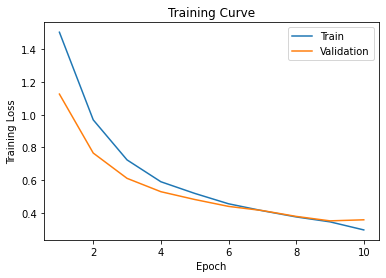

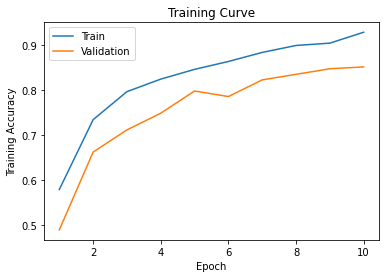

Final Training Accuracy: 0.9288659793814433
Final Validation Accuracy: 0.8518518518518519
Total time elapsed: 55.34 seconds


In [11]:
use_cuda = True
vggClassifier = VGGClassifier()
if use_cuda and torch.cuda.is_available():
    vggClassifier.cuda()
    print('CUDA is available, training on GPU ...')
else:
    print('CUDA is not available, training on CPU ...')
train(vggClassifier, get_data_loader, batch_size=128, num_epochs=10, lr=0.001, momentum=0.9)

Save the trained classifier for testing and real-time use.

In [12]:
model_save_name = 'vgg_classifier_gesture_training_dataset_bs=128_e=10_lr=0.001_m=0.9.pt'
fileName = F"/content/drive/My Drive/ECE496/machine_learning_pipeline/{model_save_name}" 
torch.save(vggClassifier.state_dict(), fileName)